In [14]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

pd.set_option('mode.chained_assignment', None)

C:\Users\hoang\Documents


In [3]:
bbo_csv_path = "BTCBUSD-bookTicker-2023-05-30.csv"
trade_csv_path = "BTCBUSD-trades-2023-05-30.csv"

In [4]:
# Read data into dataframe and do some sanity check
trades = pd.read_csv(trade_csv_path)
bbo_updates = pd.read_csv(bbo_csv_path)
trades['time'] = pd.to_datetime(trades['time'], unit='ms')
bbo_updates['event_time'] = pd.to_datetime(bbo_updates['event_time'], unit='ms')
bbo_updates['transaction_time'] = pd.to_datetime(bbo_updates['transaction_time'], unit='ms')

display(trades.head(2))
display(bbo_updates.head(2))


,id,price,qty,quote_qty,time,is_buyer_maker
0,453502050,27735.9,0.013,360.5667,2023-05-30 00:00:00.400,False
1,453502051,27735.9,0.032,887.5488,2023-05-30 00:00:00.400,False


,update_id,best_bid_price,best_bid_qty,best_ask_price,best_ask_qty,transaction_time,event_time
0,2893153122990,27735.8,5.522,27735.9,13.947,2023-05-30 00:00:00.006,2023-05-30 00:00:00.011
1,2893153124633,27735.8,5.564,27735.9,13.947,2023-05-30 00:00:00.020,2023-05-30 00:00:00.023


To estimate the parameters of the function 

$$f = A exp(-k \delta)$$
$$A = \frac{\Lambda}{\alpha}$$
$$k = \alpha K$$

where 

$\delta$ is the input spread.

$\Lambda$ is the constant intensity of market order.

$\alpha$ is the market impact factor.

$K$  being a scaling parameter for the temporary impact of a market order.

We will need to estimate the following parameters from the data, or at least infer them from literature.
1. The arrival rate of the market orders.
2. The distribution parameter of the size of market orders with the pdf
$$f^Q(x) \sim x^{-1-\alpha} $$
for market order of size $x$, i.e. a power-law dstribution for the size of market order.
3. The temporary market impact of each market order
$$\Delta p \sim ln(Q)$$
for order of size $Q$.

The idea of the formula is relatively straightforward: we assume market order arrives at random times based on a Poisson process with constant intensity $\Lambda$, and the size of each market order is also random following a power-law function $f^Q$. We then can estimate the market impact of the market order at the time of the arrival. The market impact will then tell us how "deep" the market order penetrates the order book, and from the impact distance we can estimate whether our limit order will be filled or not.

In the paper "High-frequency trading in a limit order book" where the Poisson formula originated from, the authors asssume  that the arrive rate of market order is constant. We first plot the average arrival rate per second of the market order to check this assumption

C:\Users\hoang\AppData\Local\Temp\ipykernel_18816\3323377250.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  trade_intensity = trades.groupby('minute').sum()['count']/60.0


minute
0    5.100000
1    1.800000
2    2.816667
3    0.516667
4    0.516667
Name: count, dtype: float64

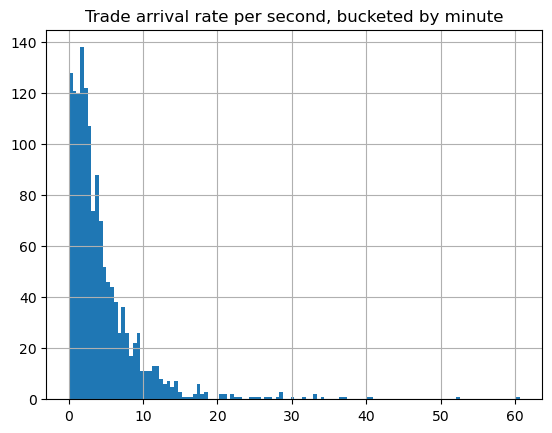

In [5]:
trades['count'] = 1
trades['minute'] = trades['time'].dt.hour*60 + trades['time'].dt.minute
trade_intensity = trades.groupby('minute').sum()['count']/60.0
display(trade_intensity.head())
trade_intensity.hist(bins=120)
plt.title('Trade arrival rate per second, bucketed by minute')
plt.show()

We can see that the arrival rate is not constant, but follows an exponential function
$$\Lambda \sim Exp(\theta)$$
where $\theta$ can be estimated as:
$$\theta = \frac{n}{\sum{x_i}}$$
where $n$ is number of observation windows and $x_i$ are the estimated intensity during that window. The median estimator of the market order arrival rate is then:

In [6]:
theta = len(trade_intensity)/sum(trade_intensity)

var_Lambda = np.log(2)/theta
print("Lambda: %f" %(var_Lambda))

Lambda: 3.126278


Next we estimate the order size distribution of market order using power law function. First we plot the histogram of the average size per second:

C:\Users\hoang\AppData\Local\Temp\ipykernel_18816\2921839720.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  average_size = trades.groupby('minute').mean()['qty']


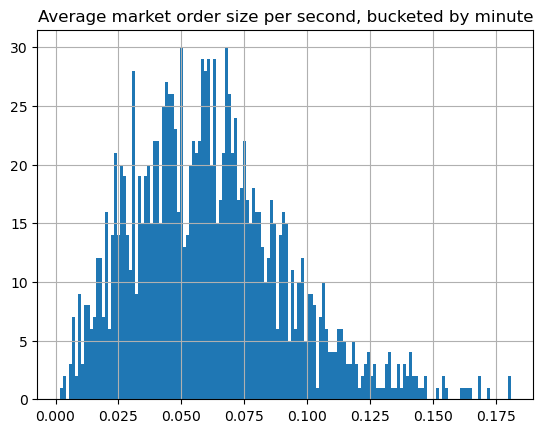

In [7]:
average_size = trades.groupby('minute').mean()['qty']
hist = average_size.hist(bins=150)
plt.title('Average market order size per second, bucketed by minute')
plt.show()

We then can estimate the power-law distribution of the market order's size, up to a normalzing constant as follows:

In [8]:
from scipy.optimize import minimize

def func_powerlaw(x,alpha):
    return x**(-1-alpha)/alpha
count, division = np.histogram(average_size,bins = np.linspace(0,0.15,50))
x = division[1:]
y = count/sum(count)
n = len(x)
def sse(v):
    # We dont accept negative alpha
    if v<=0:
        return 99999999999999999999999
    r = 0
    for i in range(0, n):
        r += (func_powerlaw(x[i], v) - y[i])**2
    return  r
res = minimize(sse, 1.5, method='Nelder-Mead', tol=1e-6)
var_alpha = res.x

test_order_size = 0.1
print("alpha: %f" % (var_alpha))

alpha: 0.183190


Finally, we need to estimate the scaling paramater $K$. Roughly speaking, the market impact functional form:
$$ln(Q) \sim \Delta p$$
tells us for a given market order size $Q$, what is the expected price impact $\Delta p$ (can be in terms of basis points for consistency). A simple mapping of total market order size per second and the corresponding price movements should yield the function estimator:

In [9]:
bbo_updates["price"] = (bbo_updates["best_bid_price"] + bbo_updates["best_ask_price"])/2
bbo_updates['time'] =  bbo_updates['event_time']
mid_price_data = bbo_updates[['time', 'price']]
trade_bbo_df = pd.merge_asof(trades, mid_price_data, on='time',  tolerance=pd.Timedelta("10s"),suffixes =['_trade','_bbo'])


In [10]:
trade_bbo_df['bucket_mark'] = trade_bbo_df['time'].dt.hour*60+ trade_bbo_df['time'].dt.minute
impact_df = trade_bbo_df.groupby('bucket_mark').agg(
    Qty=('qty', np.sum),
    Px=('price_bbo', np.mean))
impact_df['ImpactBps']= abs(impact_df['Px'].pct_change())*100
impact_df.dropna(inplace=True)
def func_mkt_impact(x,K):
    return np.log(x)/K
x = [v for v in impact_df['Qty'].tolist()]
y = [v for v in impact_df['ImpactBps'].tolist()]
n = len(x)
def sse(v):
    r = 0
    for i in range(0, n):
        r += (func_mkt_impact(x[i], v) - y[i])**2
    return  r
res = minimize(sse, 1.5, method='Nelder-Mead', tol=1e-6)
var_K = res.x[0]
print("K: %f" % (var_K))

K: 96.150530


Finally we can input all the paramters and calculate the executed intensity of our limit orders given quote spread in terms of basis points:

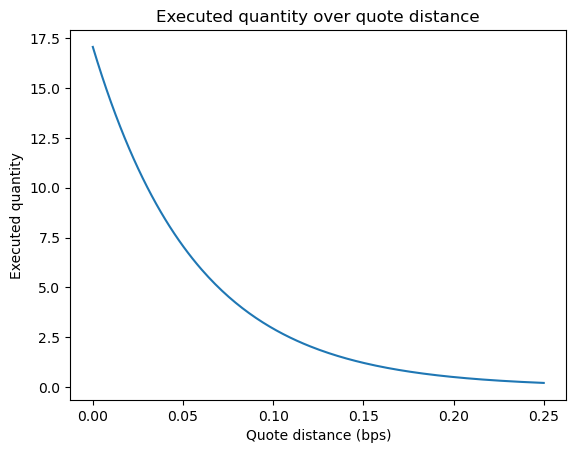

In [11]:
A = var_Lambda/var_alpha
k = var_K*var_alpha
def exec_intensity(spread):
    return A*np.exp(-k*spread)
x = np.linspace(0,0.25,200)
y = [exec_intensity(v) for v in x]
plt.plot(x,y)
plt.xlabel('Quote distance (bps)');
plt.ylabel('Executed quantity');
plt.title('Executed quantity over quote distance');

We then can impose some uncertainty around the executed quantity functional form by impose a distribution around one or all of its parameters. Recall the arrival intensity parameters $\Lambda$ of the market order;s Poisson function follows exponential distribution with mean $\theta$. The 95% confidence interval of $\Lambda$ is then:

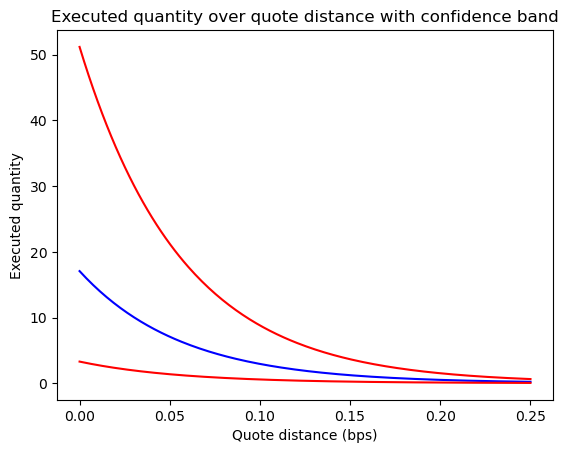

In [12]:
from scipy.stats import expon

Lambda_range = expon.interval(0.75, scale=1/theta)
A_mean = var_Lambda/var_alpha
A_lower = Lambda_range[0]/var_alpha
A_upper = Lambda_range[1]/var_alpha

k = var_K*var_alpha
def exec_intensity(A, spread):
    return A*np.exp(-k*spread)
x = np.linspace(0,0.25,200)
y = [exec_intensity(A_mean, v) for v in x]
y_upper = [exec_intensity(A_upper, v) for v in x]
y_lower = [exec_intensity(A_lower, v) for v in x]


plt.plot(x,y, color='b')
plt.plot(x,y_upper, color='r')
plt.plot(x,y_lower, color='r')

plt.xlabel('Quote distance (bps)');
plt.ylabel('Executed quantity');
plt.title('Executed quantity over quote distance with confidence band');